<a href="https://colab.research.google.com/github/nandinisitlani2/ML-Projects/blob/main/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-07 10:29:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-07 10:29:35 (92.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [8]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys

In [9]:
import tensorflow_datasets as tfds

In [10]:
tensorflow_datasets_list=tfds.list_builders()
print("food101" in tensorflow_datasets_list)

True


In [11]:
(train_data,test_data),ds_info=tfds.load(name="food101",
                                         split=["train","validation"],
                                         as_supervised=True,
                                         with_info=True,
                                         shuffle_files=True)

In [12]:
class_names=ds_info.features["label"].names

In [13]:
train_1_sample=train_data.take(1)


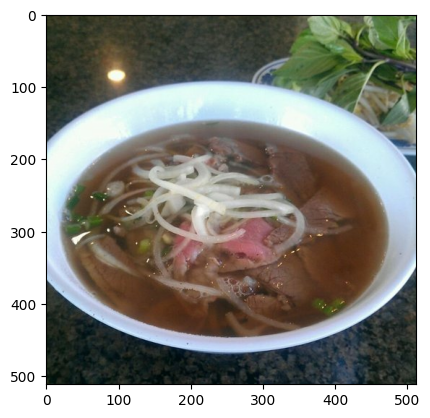

In [73]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.imshow(image)

In [72]:
for image,label in train_1_sample:
  print(f"""
  image_shape:{image.shape}
  image_datatype:{image.dtype}
  """)


  image_shape:(512, 512, 3)
  image_datatype:<dtype: 'uint8'>
  


In [17]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 165, 121],
        [185, 161, 117],
        [181, 157, 113],
        ...,
        [111,  72,  33],
        [103,  64,  25],
        [ 94,  55,  16]],

       [[186, 162, 118],
        [183, 159, 115],
        [180, 156, 112],
        ...,
        [122,  83,  40],
        [113,  74,  31],
        [105,  66,  23]],

       [[180, 156, 112],
        [178, 154, 110],
        [177, 153, 109],
        ...,
        [132,  94,  45],
        [124,  87,  35],
        [120,  83,  31]],

       ...,

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [231, 225, 191],
        [231, 225, 189],
        [231, 226, 188]],

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [230, 224, 190],
        [230, 224, 188],
        [229, 223, 187]],

       [[206, 203, 158],
        [204, 200, 153],
        [203, 195, 146],
        ...,
        [229, 223, 18

## Preprocessing data

In [18]:
def preprocess_image(image,label,IMG_SHAPE=224):
  image=tf.image.resize(image,size=[IMG_SHAPE,IMG_SHAPE])
  #image=image/255 #not required with efficientnet v2
  return tf.cast(image,dtype=tf.float32),label

In [19]:
train_data=train_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE) ## no of parallel calls allows to use as many as available gpu possible to process images as there are a lot of images to process

train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

test_data=test_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
test_data=test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Callbacks

In [21]:
from helper_functions import create_tensorboard_callback

In [22]:
checkpoint_path="model_checkpoint/cp/.ckpt"

model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    monitor="val_loss",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=1)

## Mixed Precision Training

In [23]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# mixed precision utilizes float 16 and 32 for faster computation when possible

In [24]:
from tensorflow.keras import layers
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=input_shape)
x=base_model(inputs,training=False)

x=layers.GlobalAveragePooling2D()(x)

x=layers.Dense(101)(x)

outputs=layers.Activation("softmax",dtype=tf.float32)(x)

model=tf.keras.Model(inputs,outputs)

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                 metrics=["accuracy"])

In [29]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_2 True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
activation True float32 <Policy "float32">


In [30]:
model.fit(train_data,
          epochs=3,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.25*len(test_data)),
          callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                 experiment_name="101 classes all data"),
                    model_checkpoint
                    ])

Saving TensorBoard log files to: training_logs/101 classes all data/20230507-103135
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7138 - accuracy: 0.5828
Epoch 1: val_loss improved from inf to 1.14066, saving model to model_checkpoint/cp/.ckpt
2368/2368 [==============================] - 199s 77ms/step - loss: 1.7138 - accuracy: 0.5828 - val_loss: 1.1407 - val_accuracy: 0.6986
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1982 - accuracy: 0.6905
Epoch 2: val_loss improved from 1.14066 to 1.03935, saving model to model_checkpoint/cp/.ckpt
2368/2368 [==============================] - 187s 78ms/step - loss: 1.1981 - accuracy: 0.6905 - val_loss: 1.0393 - val_accuracy: 0.7145
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0529 - accuracy: 0.7243
Epoch 3: val_loss improved from 1.03935 to 1.00010, saving model to model_checkpoint/cp/.ckpt
2368/2368 [==============================] - 187s 78ms/step - loss: 1.0528 

In [31]:
model.evaluate(test_data)

790/790 [==============================] - 55s 68ms/step - loss: 1.0005 - accuracy: 0.7270


[1.00052809715271, 0.7270495295524597]

In [80]:
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable=True
for layer in base_model.layers[:-10]:
 layer.trainable=True


inputs=layers.Input(shape=(224,224,3))
x=base_model(inputs,training=False)

x=layers.GlobalAveragePooling2D()(x)

x=layers.Dense(101)(x)

outputs=layers.Activation("softmax",dtype=tf.float32)(x)

model_2=tf.keras.Model(inputs,outputs)

In [81]:
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

In [82]:
history_2=model_2.fit(train_data,
          epochs=3,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.25*len(test_data)),
          callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                 experiment_name="101 classes all data"),
                    model_checkpoint
                    ])

Saving TensorBoard log files to: training_logs/101 classes all data/20230507-113058
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0097
Epoch 1: val_loss did not improve from 0.95300
2368/2368 [==============================] - 454s 148ms/step - loss: nan - accuracy: 0.0097 - val_loss: nan - val_accuracy: 0.0079
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0099
Epoch 2: val_loss did not improve from 0.95300
2368/2368 [==============================] - 320s 134ms/step - loss: nan - accuracy: 0.0099 - val_loss: nan - val_accuracy: 0.0081
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0099
Epoch 3: val_loss did not improve from 0.95300
2368/2368 [==============================] - 315s 132ms/step - loss: nan - accuracy: 0.0099 - val_loss: nan - val_accuracy: 0.0076


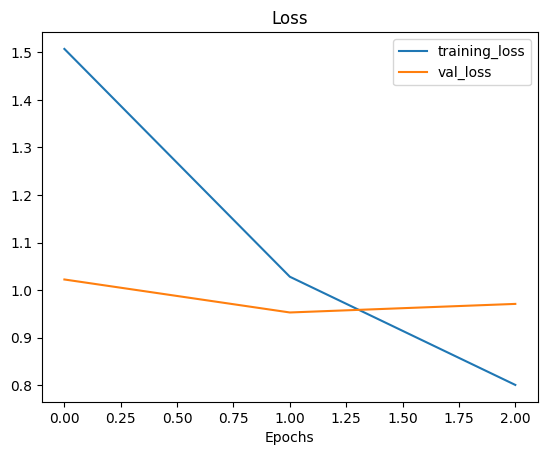

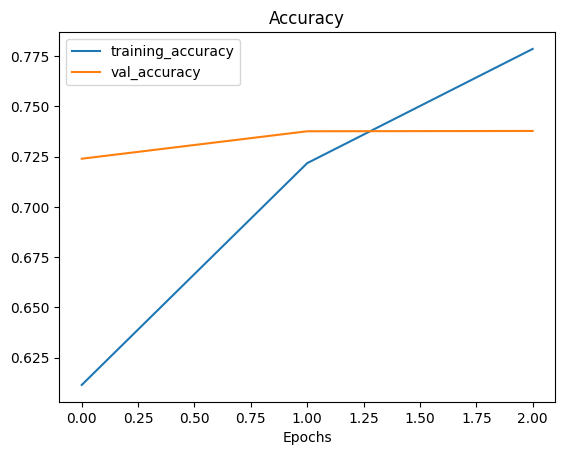

In [76]:
plot_loss_curves(history_2)

In [78]:
model_2.evaluate(test_data)

790/790 [==============================] - 62s 74ms/step - loss: 0.9613 - accuracy: 0.7432


[0.9612917900085449, 0.7432475090026855]

In [51]:
pred_probs=model_2.predict(test_data)

790/790 [==============================] - 61s 69ms/step


In [64]:
pred_classes=pred_probs.argmax(axis=1)

In [75]:
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [56]:
from sklearn.metrics import accuracy_score
sklearn_accuracy=accuracy_score(y_true=y_labels,
                                y_pred=pred_classes)

In [57]:
from helper_functions import make_confusion_matrix

In [58]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

/content/helper_functions.py:65: RuntimeWarning: invalid value encountered in true_divide
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it


In [59]:
#class_names=test_data.class_names
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                      y_pred=pred_classes))
classification_report_dict=classification_report(y_labels,pred_classes,output_dict=True)

              precision    recall  f1-score   support

           0       1.00      0.01      0.02     25250
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

In [60]:
classesF1_scores={}

for k,v in classification_report_dict.items():
  if k=="accuracy":
   break

  else:
    classesF1_scores[class_names[int(k)]]=v["f1-score"]

classesF1_scores

{'apple_pie': 0.016885921853524447,
 'baby_back_ribs': 0.0,
 'baklava': 0.0,
 'beef_carpaccio': 0.0,
 'beef_tartare': 0.0,
 'beet_salad': 0.0,
 'beignets': 0.0,
 'bibimbap': 0.0,
 'bread_pudding': 0.0,
 'breakfast_burrito': 0.0,
 'bruschetta': 0.0,
 'caesar_salad': 0.0,
 'cannoli': 0.0,
 'caprese_salad': 0.0,
 'carrot_cake': 0.0,
 'ceviche': 0.0,
 'cheesecake': 0.0,
 'cheese_plate': 0.0,
 'chicken_curry': 0.0,
 'chicken_quesadilla': 0.0,
 'chicken_wings': 0.0,
 'chocolate_cake': 0.0,
 'chocolate_mousse': 0.0,
 'churros': 0.0,
 'clam_chowder': 0.0,
 'club_sandwich': 0.0,
 'crab_cakes': 0.0,
 'creme_brulee': 0.0,
 'croque_madame': 0.0,
 'cup_cakes': 0.0,
 'deviled_eggs': 0.0,
 'donuts': 0.0,
 'dumplings': 0.0,
 'edamame': 0.0,
 'eggs_benedict': 0.0,
 'escargots': 0.0,
 'falafel': 0.0,
 'filet_mignon': 0.0,
 'fish_and_chips': 0.0,
 'foie_gras': 0.0,
 'french_fries': 0.0,
 'french_onion_soup': 0.0,
 'french_toast': 0.0,
 'fried_calamari': 0.0,
 'fried_rice': 0.0,
 'frozen_yogurt': 0.0,
 'g

In [61]:
import pandas as pd

fi_scores=pd.DataFrame({"class_names":list(classesF1_scores.keys()),
                        "f1_scores":list(classesF1_scores.values())}).sort_values("f1_scores",ascending=False)

In [62]:
fi_scores

,class_names,f1_scores
0,apple_pie,0.016886
64,miso_soup,0.000000
74,peking_duck,0.000000
73,panna_cotta,0.000000
72,pancakes,0.000000
...,...,...
31,donuts,0.000000
30,deviled_eggs,0.000000
29,cup_cakes,0.000000
28,croque_madame,0.000000


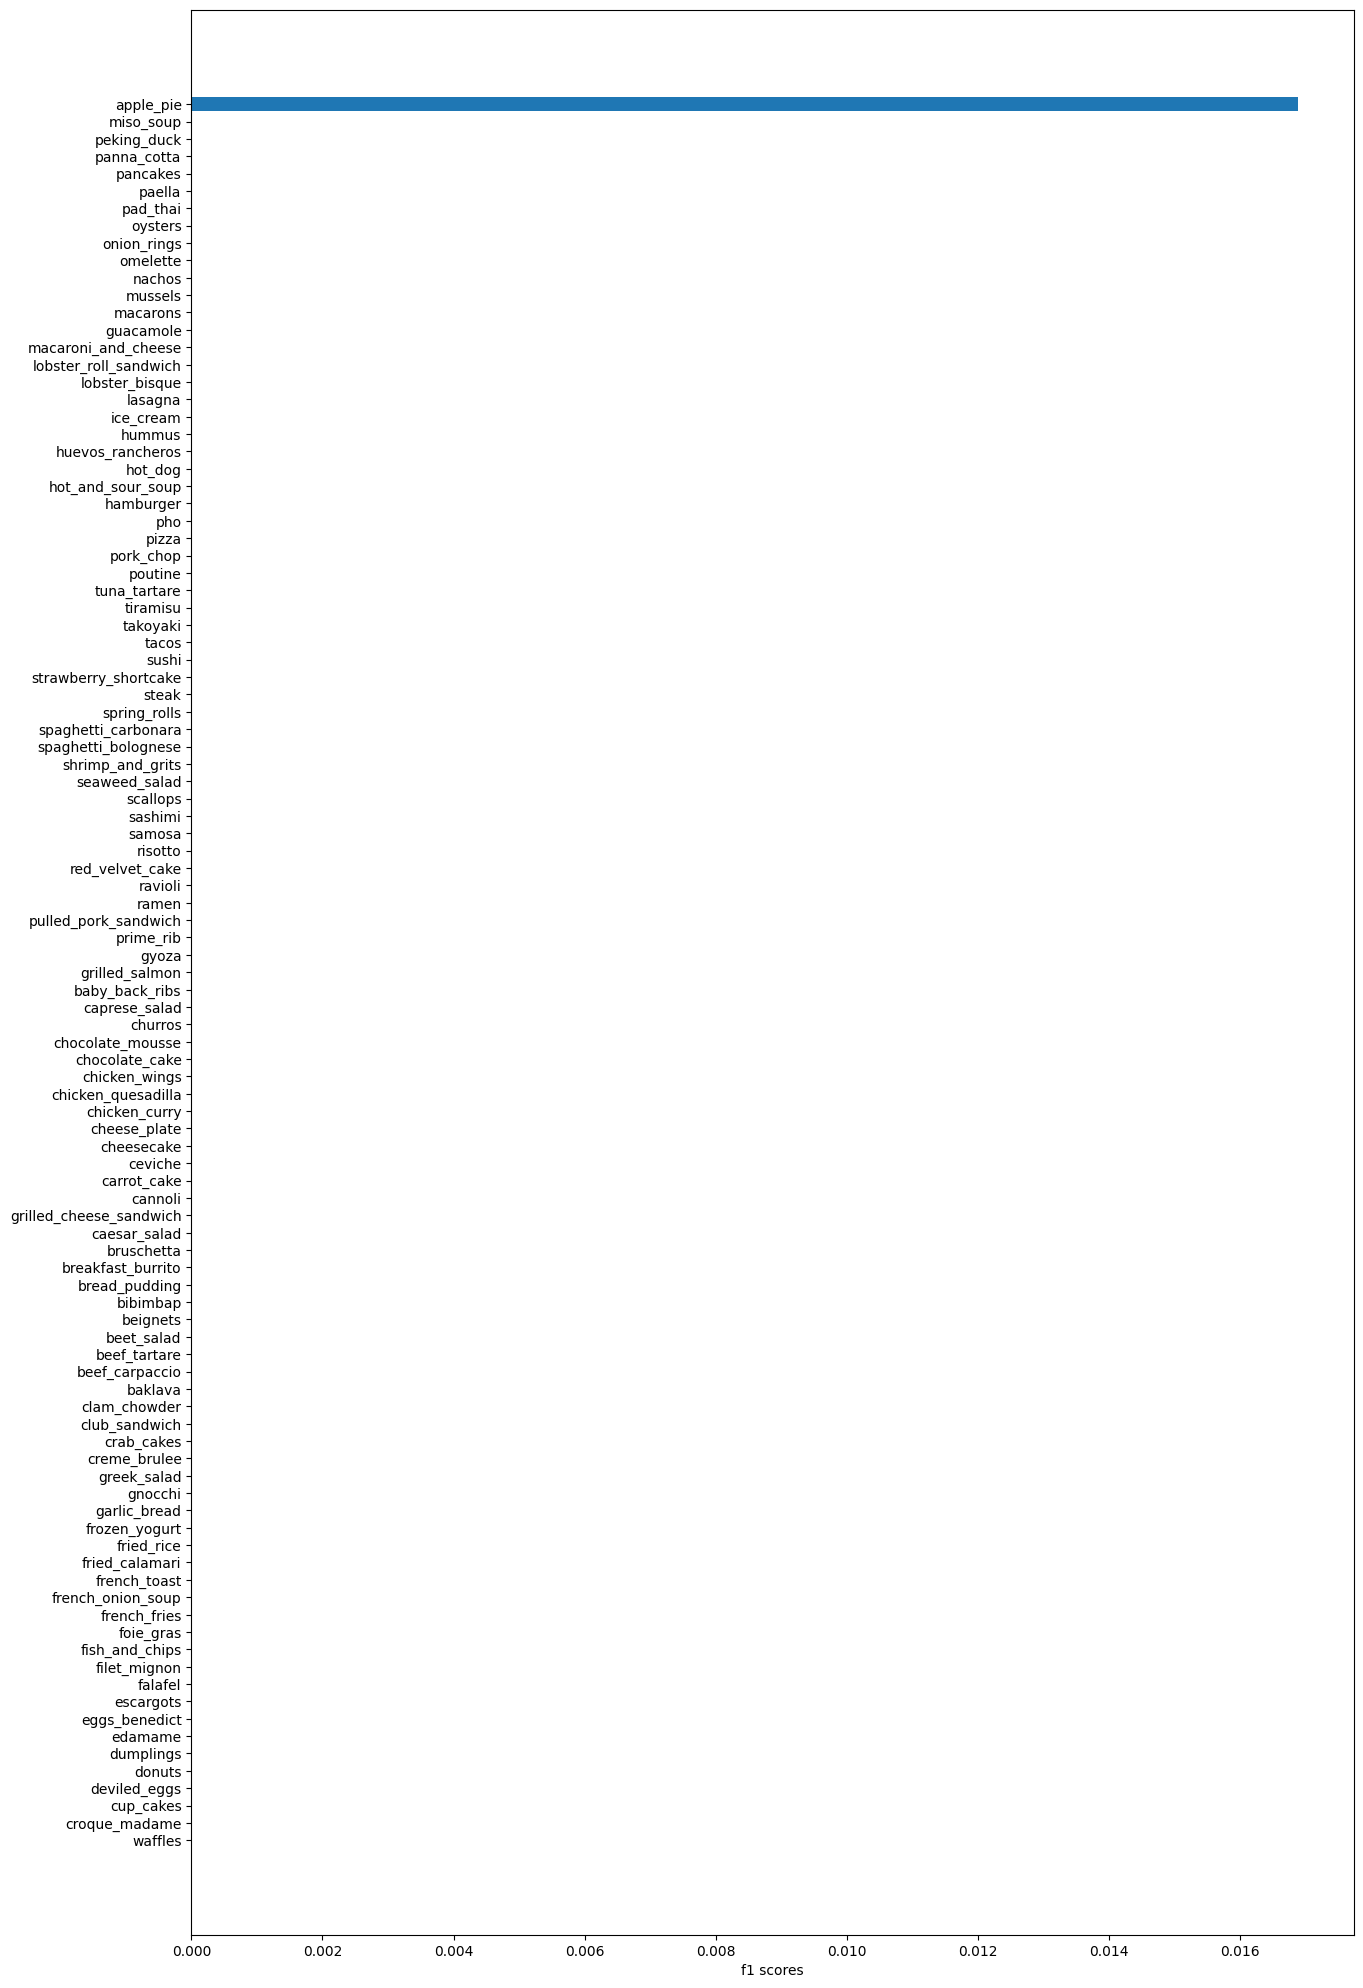

In [63]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(15,25))
scores=ax.barh(range(len(fi_scores)),fi_scores["f1_scores"].values)
ax.set_yticks(range(len(fi_scores)))
ax.set_yticklabels(fi_scores["class_names"])
plt.xlabel("f1 scores")
ax.invert_yaxis();

In [70]:
len(train_data)

2368

In [71]:
len(test_data)

790

In [79]:
len(pred_classes)

101